# Population densities

In [ ]:
using Rasters, ArchGDAL
using GeoJSON
using Plots
using Printf

In [ ]:
using PolygonAlgorithms
using PolygonAlgorithms: x_coords, y_coords

In [ ]:
using Revise
includet("modules/geoJSON.jl")
includet("modules/projection.jl")
includet("modules/affine.jl")
includet("modules/reproject.jl")
includet("modules/area.jl")

# Boundary data

Source: https://www.geoboundaries.org/

London

In [ ]:
london_boroughs = Set([
    "City of London", "Westminster", "Kensington and Chelsea", "Hammersmith and Fulham", "Wandsworth", "Lambeth",
    "Southwark", "Tower Hamlets", "Hackney", "Islington", "Camden", "Brent", "Ealing", "Hounslow", "Richmond upon Thames",
    "Kingston upon Thames", "Merton", "Sutton", "Croydon", "Bromley", "Lewisham", "Greenwich", "Bexley", "Havering",
    "Barking and Dagenham", "Redbridge", "Newham", "Waltham Forest","Haringey", "Enfield", "Barnet", "Harrow",
    "Hillingdon"
]);
inner_city_boroughs = Set([
    "Islington", "Camden", "Westminster", "Southwark", "Tower Hamlets", "Hackney", "Lambeth"
]);

In [ ]:
data_dir = "C:\\Users\\sinai\\Documents\\Projects\\Python\\Geospatial\\data"
geojson_filepath = joinpath(data_dir, "geoBoundaries-GBR-ADM2-all\\geoBoundaries-GBR-ADM2.geojson");
shape_data = GeoJSON.read(geojson_filepath)

FeatureCollection with 216 Features

In [ ]:
london_borough_features = filter_features(shape_data, :shapeName, london_boroughs);

## Plotting

In [ ]:
function plot_geometry!(canvas, geometry::GeoJSON.AbstractGeometry; options...)
    throw("Feature geomtery of $type_ is not supported")
end

function plot_geometry!(canvas, geometry::GeoJSON.Polygon; options...)
    for region in geometry.coordinates
        plot!(canvas, [Shape(region)]; options...)
    end
    canvas
end

function plot_geometry!(canvas, geometry::GeoJSON.MultiPolygon; options...)
    for polygon in geometry.coordinates
        for region in polygon
            plot!(canvas, [Shape(region)]; options...)
        end
    end
    canvas
end

plot_geometry! (generic function with 3 methods)

In [ ]:
features = london_borough_features
region_name = "London";

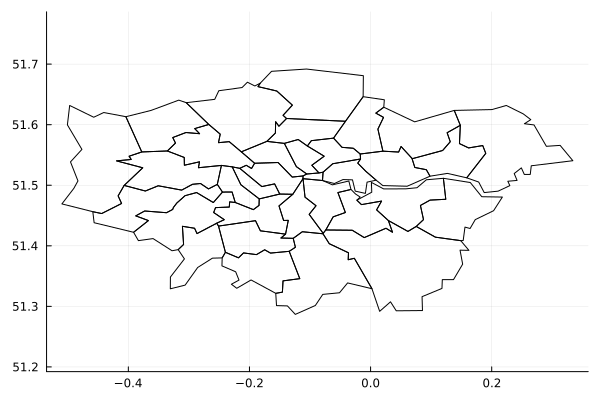

In [ ]:
canvas = plot(aspect_ratio=:equal)
for (idx, shape) in enumerate(features)
    plot_geometry!(canvas, shape.geometry; label="", color=:black, fillalpha=0.0)
end
canvas

# Reproject

In [ ]:
polygons = [feat.geometry.coordinates[1] for feat in features]
long_min, lat_min, long_max, lat_max = PolygonAlgorithms.bounds(polygons)
bounding_box = PolygonAlgorithms.box(long_min, lat_min, long_max, lat_max)
bbox_polygon = GeoJSON.Polygon(; bbox=nothing, coordinates=[bounding_box])

2D Polygonwith 1 sub-geometries

In [ ]:
long_avg = (long_min + long_max)/2
lat_avg = (lat_min + lat_max)/2
print(long_avg, " ", lat_avg)

-0.08786245 51.489315

In [ ]:
src_proj = WorldGeodeticSystem84()
radius = earth_radius_at_latitude(lat_avg)
dest_proj = TransverseMercator(;long0=long_avg, radius=radius, k=0.001f0) # convert to km

TransverseMercator{Float32}(radius=6.365018e6, long0=-0.08786245, k=0.001)

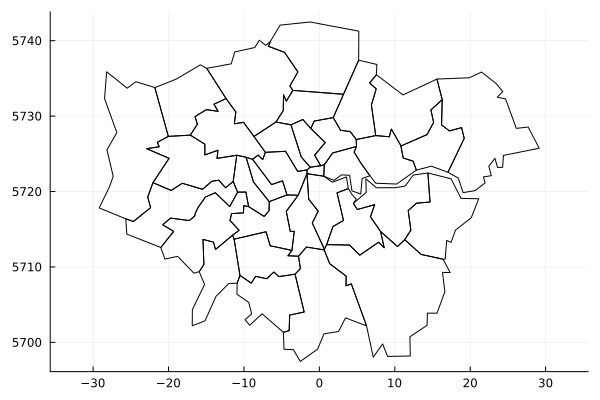

In [ ]:
canvas = plot(aspect_ratio=:equal)
for (idx, shape) in enumerate(features)
    projected = reproject(shape, src_proj, dest_proj)
    plot_geometry!(canvas, projected.geometry; label="", color=:black, fillalpha=0.0)
end
canvas

## Population Data

Source: https://hub.worldpop.org/

In [ ]:
raster_filepath = joinpath(data_dir, "gbr_ppp_2020_constrained.tif")

"C:\\Users\\sinai\\Documents\\Projects\\Python\\Geospatial\\data\\gbr_ppp_2020_constrained.tif"

In [ ]:
raster = Raster(raster_filepath)

12496×13196 Raster{Float32,2} with dimensions: 
  X Projected{Float64} LinRange{Float64}(-8.65042, 1.76208, 12496) ForwardOrdered Regular Intervals crs: WellKnownText,
  Y Projected{Float64} LinRange{Float64}(60.8604, 49.8646, 13196) ReverseOrdered Regular Intervals crs: WellKnownText
and reference dimensions: 
  Band Categorical{Int64} 1:1 ForwardOrdered
extent: Extent(X = (-8.650416617, 1.7629166749999985), Y = (49.864583335, 60.861249958))missingval: -99999.0f0crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
parent:
               60.8604      60.8596      60.8587  …      49.8654      49.8646
 -8.65042  -99999.0     -99999.0     -99999.0        -99999.0     -99999.0
 -8.64958  -99999.0     -99999.0     -99999.0        -99999.0  

In [ ]:
@time areas, population_counts, population_densities = calc_density_per_area(raster, features, src_proj);
population_densities *= 1e6 # convert to people / km^2
@printf("popluation counts max: %9d people\n", maximum(population_counts))
@printf("popluation counts sum: %9d people\n", sum(population_counts))
@printf("areas max: %8.2f km^2\n", maximum(areas) /1e6)
@printf("areas sum: %8.2f km^2\n", sum(areas) /1e6)
@printf("population densities max: %8.2f people/km^2\n", maximum(population_densities))

  7.854039 seconds (9.18 M allocations: 586.084 MiB, 6.91% gc time, 99.62% compilation time)
popluation counts max:    396698 people
popluation counts sum:   9184065 people
areas max:   149.68 km^2
areas sum:  1577.38 km^2
population densities max: 16030.50 people/km^2


In [ ]:
color_map = :viridis
color_grad = cgrad(color_map)

In [ ]:
origin = reproject([(long_avg, lat_avg)], src_proj, dest_proj)

1-element Vector{Tuple{Float32, Float32}}:
 (0.0, 5719.975)

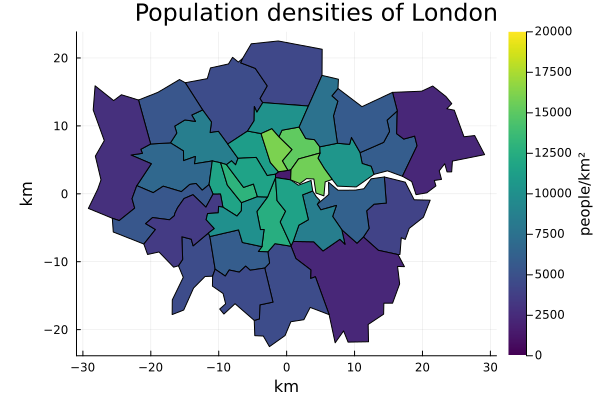

In [ ]:
canvas = plot(aspect_ratio=:equal)
vmax = 20_000
for (idx, shape) in enumerate(features)
    projected = reproject(shape, src_proj, dest_proj)
    projected = translate(projected, (0.0f0, -origin[1][2]))
    color = get(color_grad, population_densities[idx] / vmax)
    plot_geometry!(canvas, projected.geometry, label="", color=color)
end
plot!(canvas, 
    plot_title="Population densities of $region_name",
    xlabel="km",
    ylabel="km",
)
# hack: plot point off grid to force a colorbar
scatter!(
    canvas, [-1000], [-1000], zcolor=[0.0], label="",
    xlims=xlims(canvas), ylims=ylims(canvas),
    clims=(0, vmax), 
    cmap=color_map,
    colorbar_title="\npeople/km²", colorbar_titlefontrotation=0
)

In [ ]:
savefig("population_densities_$(region_name).png")

"C:\\Users\\sinai\\Documents\\Projects\\Julia\\Geospatial\\population_densities_London.png"